# The Black-Scholes hedging strategy

Work Done by : Abdelhafid Souilmi


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

## Simulating Prices Using the standard Brownian Motion :

> To simulate prices and to be able to use the numpy functions (to optimize the time cost), we first define the increments : 
$$Y_i= (\mu-\frac{\sigma^2}{2})\Delta T + \sigma \sqrt{\frac{T}{n}}Z_i$$
where $Z_i$ is a standard normal variable.

>We have then, $$S_k= S_0 exp(\sum_{i=1}^kY_i)$$

In [94]:
N,n=1000,150
T,S0,sigma,r=1.5,100,0.3,0.05

deltaT=T/n

mu_values=np.array([0.02,0.05,0.45])
Z=np.sqrt(deltaT)*np.random.normal(size=(N,n))


S=np.zeros((N,n,mu_values.shape[0]))
for i in range(mu_values.shape[0]):
    increments= (mu_values[i]-sigma**2/2)* deltaT+ sigma*Z
    S[:,:,i]= S0*np.exp(np.cumsum(increments,axis=1))

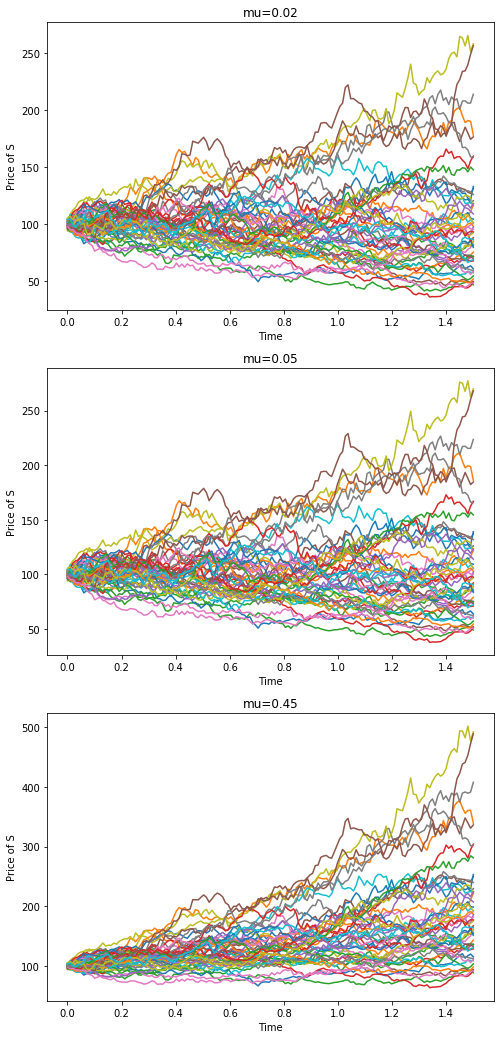

In [95]:
plt.figure(figsize=(8,18))

for i in range(len(mu_values)):
    plt.subplot(len(mu_values),1,i+1)
    for j in range(50): #plotting only and first 20 samples
        plt.title('mu={}'.format(mu_values[i]))
        plt.plot(np.linspace(0,T,n),S[j,:,i])
        plt.xlabel('Time')
        plt.ylabel('Price of S')
    
plt.show()

## Sample Mean & Variance :

> Using the Laplace function of a standard gaussian variable, and knowing that $S_t= S_0 exp( (\mu-\frac{\sigma^2}{2})t -\sigma \sqrt{t} Z$, with $Z$ a standard gaussian variable, we have :
$$\mathbf{E}[S_t] = S_0 e^{\mu t}$$

In [96]:
#sample mean and sample var
sampleMean, sampleVar= np.mean(S,axis=0), np.var(S,axis=0)

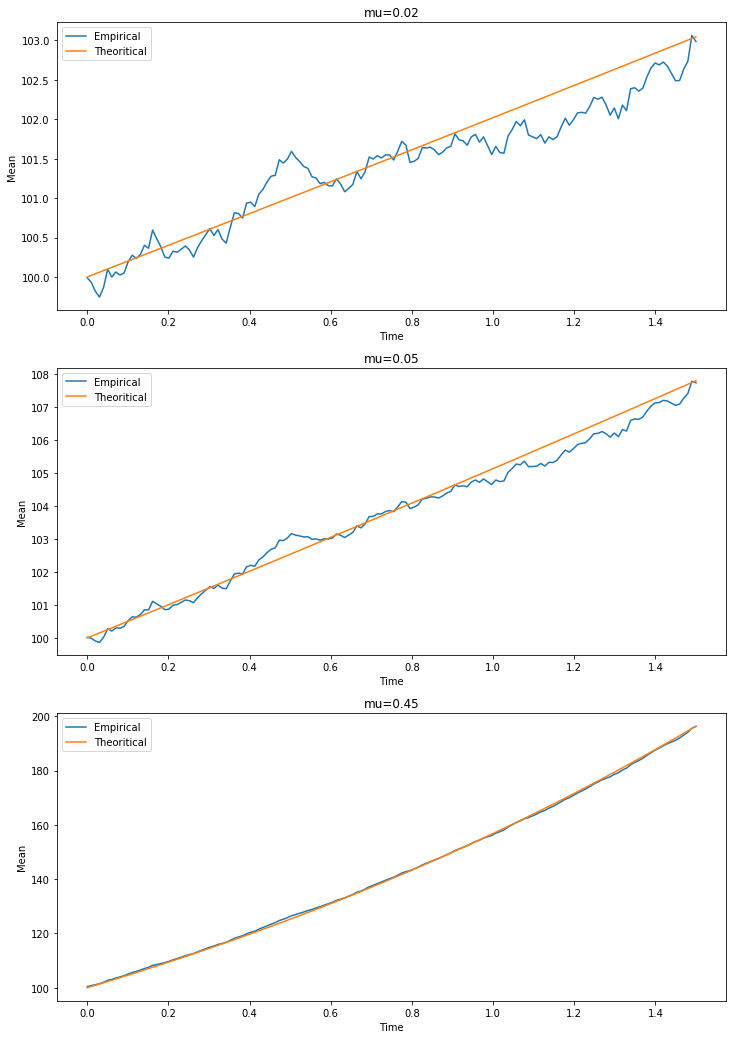

In [97]:
x=np.linspace(0,T,n)

plt.figure(figsize=(12,18))

plt.subplot(3,1,1)
plt.title('mu={}'.format(mu_values[0]))
plt.plot(x,sampleMean[:,0],label='Empirical')
plt.plot(x,S0*np.exp(mu_values[0]*x), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.title('mu={}'.format(mu_values[1]))
plt.plot(x,sampleMean[:,1],label='Empirical')
plt.plot(x,S0*np.exp(mu_values[1]*x), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.title('mu={}'.format(mu_values[2]))
plt.plot(x,sampleMean[:,2],label='Empirical')
plt.plot(x,S0*np.exp(mu_values[2]*x), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Mean')
plt.legend(loc='best')

> Again, using the Laplace function of a standard gaussian variable, we have :
$\mathbf{Var}[S_t] = S_0^2 e^{2\mu t} (e^{\sigma^2 t} -1)$

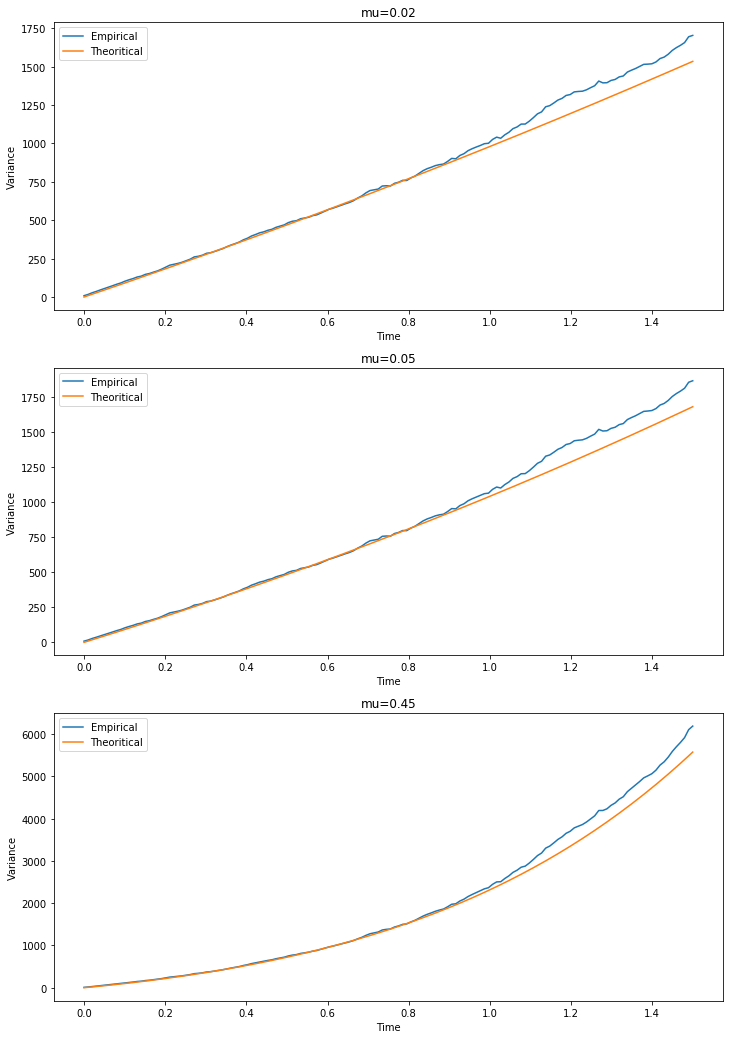

In [98]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1)
plt.title('mu={}'.format(mu_values[0]))
plt.plot(x,sampleVar[:,0],label='Empirical')
plt.plot(x,S0*S0*np.exp(2*mu_values[0]*x)* (np.exp(sigma*sigma*x)-1), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.title('mu={}'.format(mu_values[1]))
plt.plot(x,sampleVar[:,1],label='Empirical')
plt.plot(x,S0*S0*np.exp(2*mu_values[1]*x)* (np.exp(sigma*sigma*x)-1), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.title('mu={}'.format(mu_values[2]))
plt.plot(x,sampleVar[:,2],label='Empirical')
plt.plot(x,S0*S0*np.exp(2*mu_values[2]*x)* (np.exp(sigma*sigma*x)-1), label='Theoritical')
plt.xlabel('Time')
plt.ylabel('Variance')
plt.legend(loc='best')

> We see that the empirical results match, except for the mean $=0.02$. In this case the mean is so low that fluctuations added by the brownian motion can easily deviate the outcome either way (above or below).

## Hedged Strategy :

We first define the following functions as well as $BS(S_i,K,T)$ the initial no-arbitrage Black-Scholes price of a call with strike $K$, expiry date $T$ and initial price $S_0$:

In [99]:
def d1(s,k,v):
    return np.log(s/k)/np.sqrt(v)+np.sqrt(v)/2
def d2(s,k,v):
    return np.log(s/k)/np.sqrt(v)-np.sqrt(v)/2

def BS(Si,K,T):
    return Si*st.norm.cdf(d1(Si,K*np.exp(-r*T),sigma**2*T))-K*np.exp(-r*T)*st.norm.cdf(d2(Si,K*np.exp(-r*T),sigma**2*T))

We also define the following hedging strategy :

$$ we~will~hold~\Delta_t(K)~shares~of ~the~underlying~asset,~with~\Delta_t(K)= \mathcal{N}(d_+(S_t, Ke^{−r(T −t)}
, \sigma^2
(T − t))$$

In [100]:
def delta(S,K,T,t):
    return st.norm.cdf(d1(S,K*np.exp(-r*(T-t)),sigma**2*(T-t)) )

We will define a function to generate prices for different values of steps $n$.

This function gives an array of dimension (N,n,3), corresponding to the number of samples, number of steps, and the 3 different evolutions (different values of $\mu$).

The goal of this section is to calculate the capital needed to hedge the option. The capital needed can be obtained using this formula : 

$$e^{-rT}X_T^n(K) = BS(S_0,K,T)+\sum_{i=1}^n \Delta_{t_{i-1}^n}(K) (e^{-rt_i^n} S_{t_i^n} - e^{-rt_{i-1}^n} S_{t_{i-1}^n})$$

In [101]:
def generatePrices(m): 
    #generate prices for different values of time steps m
    #The output is of dim (N,m,3)
    deltaT=T/m

    mu_values=np.array([0.02,0.05,0.45])
    Z=np.sqrt(deltaT)*np.random.normal(size=(N,m))


    S=np.zeros((N,m,mu_values.shape[0]))
    for i in range(mu_values.shape[0]):
        increments= (mu_values[i]-sigma**2/2)* deltaT+ sigma*Z
        S[:,:,i]= S0*np.exp(np.cumsum(increments,axis=1))
        
    return S

In [102]:
K_values=80+ np.arange(0,41) #all values of K

def generateX(m): #Generates an array of dim (N,mu_values.shape[0],K_values.shape[0]) of X_T
    X=np.zeros((N,mu_values.shape[0],K_values.shape[0]))

    for i in range(K_values.shape[0]):
        X[:,:,i]+=BS(S0,K_values[i],T)
    
    ndeltaT= T/m
    y= np.exp(-r*np.arange(m)*ndeltaT)
    y = np.tile(y, (N, 1))

    actualizedS=np.zeros((N,m,mu_values.shape[0]))
    nS=generatePrices(m)
    
    for i in range(mu_values.shape[0]):
        actualizedS[:,:,i]=y*nS[:,:,i]

    diff= actualizedS[:,1:,:]-actualizedS[:,:-1,:] # exp(-r*ti)S_{ti} - exp(-r*t(i-1))S_{t(i-1)}


    deltaK=np.zeros((N,m-1,K_values.shape[0],mu_values.shape[0]))

    for i in range(K_values.shape[0]):
        for j in range(mu_values.shape[0]):
            for k in range(m-1):
                deltaK[:,k,i,j]=delta(S[:,k,j],K_values[i],T,ndeltaT*k)


    for i in range(K_values.shape[0]):
         X[:,:,i]+= np.sum(deltaK[:,:,i,:]*diff,axis=1)

    X*=np.exp(r*T)
    return X

In [103]:
results1= generateX(n)

> We will look at the histograms of the values of $X_T^n$.

(array([ 68., 279., 310., 173.,  94.,  48.,  15.,   8.,   3.,   2.]),
 array([-28.08242598,  15.11729996,  58.31702591, 101.51675185,
        144.71647779, 187.91620373, 231.11592968, 274.31565562,
        317.51538156, 360.71510751, 403.91483345]),
 <a list of 10 Patch objects>)

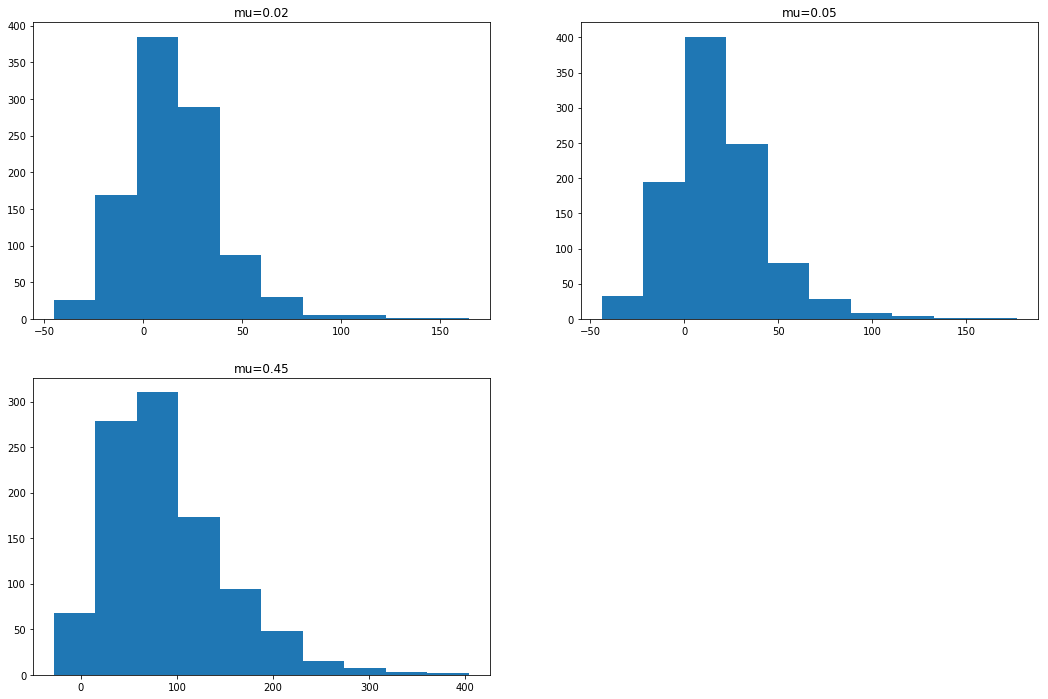

In [119]:
plt.figure(figsize=(18,12))

plt.subplot(2,2,1)
plt.title('mu={}'.format(mu_values[0]))
plt.hist(results1[:,0,20])
plt.xlabel('Values of $X_T^n$')

plt.subplot(2,2,2)
plt.title('mu={}'.format(mu_values[1]))
plt.hist(results1[:,1,20])
plt.xlabel('Values of $X_T^n$')

plt.subplot(2,2,3)
plt.title('mu={}'.format(mu_values[2]))
plt.hist(results1[:,2,20])
plt.xlabel('Values of $X_T^n$')

>We look now at the dependency of $X_T^n$ on K. We plot 3 random samples of prices for every value of $\mu$.

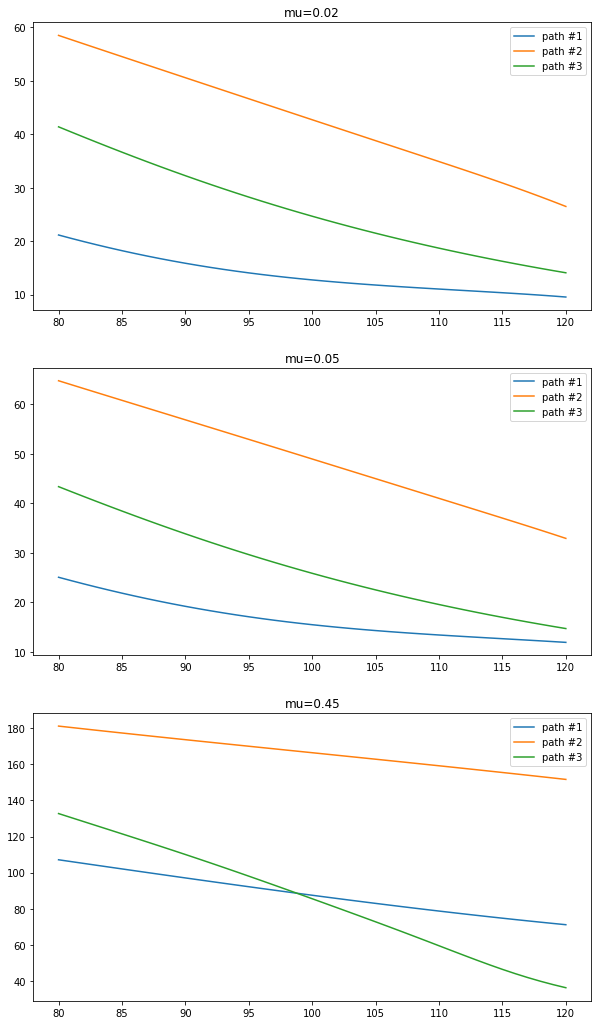

In [115]:
x=np.linspace(0,T,n)

plt.figure(figsize=(10,18))

plt.subplot(3,1,1)
plt.title('mu={}'.format(mu_values[0]))
plt.plot(K_values,results1[5,0,:],label='path #1')
plt.plot(K_values,results1[10,0,:], label='path #2')
plt.plot(K_values,results1[20,0,:], label='path #3')
plt.legend(loc='best')

plt.subplot(3,1,2)
plt.title('mu={}'.format(mu_values[1]))
plt.plot(K_values,results1[5,1,:],label='path #1')
plt.plot(K_values,results1[10,1,:], label='path #2')
plt.plot(K_values,results1[20,1,:], label='path #3')
plt.legend(loc='best')

plt.subplot(3,1,3)
plt.title('mu={}'.format(mu_values[2]))
plt.plot(K_values,results1[5,2,:],label='path #1')
plt.plot(K_values,results1[10,2,:], label='path #2')
plt.plot(K_values,results1[20,2,:], label='path #3')
plt.legend(loc='best')

## Profit and Loss

In this section we will look at the profit and loss corresponding to the hedging strategy: 
    $$PL_T^n(K)= X_T^n(K) - (S_T-K)^+$$
    

> We calculated the mean of $PL$ for 1000 sample paths.

In [141]:
def PnL(m):
    #first we generate one X_T for every value of mu and K
    X=np.zeros((N,mu_values.shape[0],K_values.shape[0]))

    for i in range(K_values.shape[0]):
        X[:,:,i]+=BS(S0,K_values[i],T)

        
    ndeltaT= T/m
    y= np.exp(-r*np.arange(m)*ndeltaT)
    
    y=np.tile(y, (N, 1))
    actualizedS=np.zeros((N,m,mu_values.shape[0]))
    nS=generatePrices(m)
    
    for i in range(mu_values.shape[0]):
        actualizedS[:,:,i]=y*nS[:,:,i]

    diff= actualizedS[:,1:,:]-actualizedS[:,:-1,:] # exp(-r*ti)S_{ti} - exp(-r*t(i-1))S_{t(i-1)}


    deltaK=np.zeros((N,m-1,K_values.shape[0],mu_values.shape[0]))

    for i in range(K_values.shape[0]):
        for j in range(mu_values.shape[0]):
            for k in range(m-1):
                deltaK[:,k,i,j]=delta(nS[:,k,j],K_values[i],T,ndeltaT*k)


    for i in range(K_values.shape[0]):
         X[:,:,i]+= np.sum(deltaK[:,:,i,:]*diff,axis=1)

    X*=np.exp(r*T)
    
    PnL=X
    finalPayoff= np.zeros((N,mu_values.shape[0],K_values.shape[0]))

    for i in range(mu_values.shape[0]):
        for j in range(K_values.shape[0]):
            finalPayoff[:,i,j]=(nS[:,-1,i]-K_values[j])* (nS[:,-1,i]>K_values[j])

    PnL-=finalPayoff
    
    PnL= np.mean(PnL,axis=0)
    return PnL

In [143]:
results= np.array([PnL(20*i) for i in range(1,11) ])

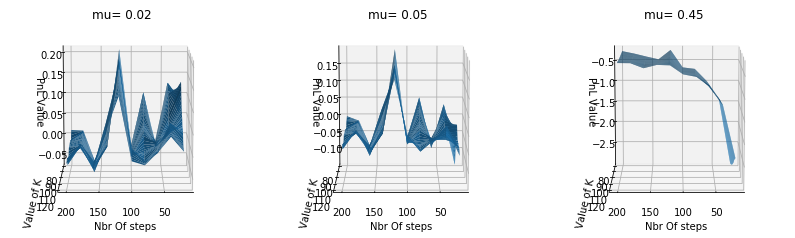

In [144]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure(figsize=(14,14))

for i in range(1,mu_values.shape[0]+1):
    x= 20*np.arange(1,results.shape[0]+1)
    X,Y=np.meshgrid(x,K_values)
    ax = fig.add_subplot(330+i, projection='3d')
    ax.plot_surface(X, Y, results[:,i-1,:].T, rstride=1, cstride=1, edgecolor='none')
    ax.view_init(10,90)
    ax.set_xlabel('Nbr Of steps')
    ax.set_ylabel('Value of K')
    ax.set_zlabel('PnL Value')
    ax.set_title('mu= {}'.format(mu_values[i-1]))

>The more steps we have the less losses we have since the hedging strategy gets enough steps to correct the behaviour of our portfolio. 

>We note the spike around $K=100=S_0$.

>For high values of $\mu$, we get a smooth  curve.